In [7]:
from poola import core as pool
import pandas as pd
import seaborn as sns
import gpplot as gpp
import matplotlib.pyplot as plt
import zipfile
import gzip
gpp.set_aesthetics(context = 'paper')

In [2]:
# readcount files
file_path = "../../Data/primaryLibrary/"
file = file_path + 'counts-GR_A549_RDB181.txt'
A549_Kox1 = pd.read_table(file)

In [3]:
A549_Kox1.head()

,Construct Barcode,Construct IDs,A549_RDB_181 repA,pDNA CP1948,A549_RDB_181 repB,Unlabeled Sample Barcodes
0,ATAGCGACGTCCGTTGGACA,ATAGCGACGTCCGTTGGACA,232,57,299,0
1,ACCCGGACTACGCCATGTTG,ACCCGGACTACGCCATGTTG,74,48,89,0
2,AGTACCCCTATTCAACCGGA,AGTACCCCTATTCAACCGGA,328,51,344,0
3,TAATCAGAGGAACTACGTTT,TAATCAGAGGAACTACGTTT,305,47,352,0
4,TATGGCTGTCACCTAGATCA,TATGGCTGTCACCTAGATCA,156,65,204,0


In [5]:
figure1_outpath = '../../Figures/Figure 1'

In [8]:
# additional information on the readcount files
design_file_path = file_path + 'essentials_nonessentials_CRISPRi_tiling_designs_v2.csv.zip'
with zipfile.ZipFile(design_file_path,'r') as zip_ref:
    zip_ref.()
#file = zipfile.ZipFile('../../Data/primaryLibrary/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv.zip','r').open('../../Data/primaryLibrary/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv.zip')
with gzip.open('../../Data/primaryLibrary/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv.zip') as f:
    ess_noness = pd.read_csv(f)
# ess_noness = pd.read_csv(file)
# ess_noness = ess_noness[['Target Gene Symbol','Target Gene ID','Category','TSS Position', 
#        'sgRNA \'Cut\' Site TSS Offset','sgRNA Sequence', 
#            'sgRNA Context Sequence', 'On-Target Ruleset',
#        'On-Target Efficacy Score']]
# ess_noness = pd.merge(col6[['Target Gene Symbol', 'sgRNA Sequence']], ess_noness)
# ess_noness.head()

BadGzipFile: Not a gzipped file (b'PK')

# process A549_Kox1


In [8]:
lognorms_A549_Kox1 = pool.lognorm_columns(reads_df=A549_Kox1, columns=['A549_RDB_181 repA','pDNA  CP1948', 'A549_RDB_181 repB'])
filtered_lognorms_lognorms_A549_Kox1 = pool.filter_pdna(lognorm_df=lognorms_A549_Kox1, pdna_cols=['pDNA  CP1948'], z_low=-3)
print('Filtered ' + str(lognorms_A549_Kox1.shape[0] - filtered_lognorms_lognorms_A549_Kox1.shape[0]) + ' rows due to low pDNA abundance')


Filtered 621 rows due to low pDNA abundance


In [9]:
lfc_df_A549_Kox1 = pool.calculate_lfcs(lognorm_df=filtered_lognorms_lognorms_A549_Kox1, 
                                         ref_col='pDNA  CP1948', target_cols=['A549_RDB_181 repA', 'A549_RDB_181 repB'])
lfc_df_A549_Kox1.head()


,Construct Barcode,Construct IDs,A549_RDB_181 repA,A549_RDB_181 repB,Unlabeled Sample Barcodes
0,ATAGCGACGTCCGTTGGACA,ATAGCGACGTCCGTTGGACA,-1.037877,-0.662310,0
1,ACCCGGACTACGCCATGTTG,ACCCGGACTACGCCATGTTG,-1.961783,-1.750208,0
2,AGTACCCCTATTCAACCGGA,AGTACCCCTATTCAACCGGA,-0.478648,-0.344259,0
3,TAATCAGAGGAACTACGTTT,TAATCAGAGGAACTACGTTT,-0.462704,-0.210463,0
4,TATGGCTGTCACCTAGATCA,TATGGCTGTCACCTAGATCA,-1.652047,-1.288802,0


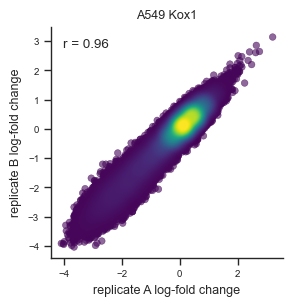

In [20]:
plt.subplots(figsize=(3,3))
gpplot.point_densityplot(data=lfc_df_A549_Kox1, x='A549_RDB_181 repA', y='A549_RDB_181 repB')
gpplot.add_correlation(data=lfc_df_A549_Kox1, x='A549_RDB_181 repA', y='A549_RDB_181 repB')
sns.despine()
plt.xlabel('replicate A log-fold change',fontsize=9)
plt.ylabel('replicate B log-fold change',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('A549 Kox1',fontsize=9)
gpp.savefig(figure1_outpath+'A549_Kox1_rep_corr.pdf',
           dpi=300, bbox_inches='tight')

In [17]:
lfc_df_A549_Kox1 = lfc_df_A549_Kox1[['Construct Barcode','A549_RDB_181 repA','A549_RDB_181 repB']]

In [18]:
avg_replicate_lfc_df_A549_Kox1 = pool.average_replicate_lfcs(lfcs=lfc_df_A549_Kox1, guide_col='Construct Barcode', condition_indices=[0],
                                                   sep='_')
avg_replicate_lfc_df_A549_Kox1.head()

,Construct Barcode,condition,avg_lfc,n_obs
0,AAAAAAAAAAAGGGCAGAAG,A549,-0.376159,2
1,AAAAAAAAAAATTAGACCTC,A549,-0.021644,2
2,AAAAAAAAAACAGGACACAG,A549,0.031810,2
3,AAAAAAAAAACGTTGTGCAG,A549,-0.722006,2
4,AAAAAAAAAACTGTTATTTG,A549,0.068155,2


In [19]:
avg_replicate_lfc_df_A549_Kox1.rename(columns={'Construct Barcode':'sgRNA Sequence'}, inplace = True)

# Calculate Z-score using Intergenic control

In [20]:
annot_guide_lfcs_A549_Kox1 = pool.annotate_guide_lfcs(avg_replicate_lfc_df_A549_Kox1, ess_noness, 'Target Gene Symbol',
                                            merge_on='sgRNA Sequence', z_score_neg_ctls=True,
                                            z_score_neg_ctl_genes='ONE_INTERGENIC')

In [21]:
labels = ['[-1000, -500)', '[-500, -400)', '[-400, -300)',
          '[-300, -200)','[-200, -100)', '[-100, -50)', '[-50, 0)',
          '[0, 50)','[50, 100)', '[100, 200)', '[200, 300)',
          '[300, 400)','[400, 500)', '[500, 1000)',]

cut_list =  [-1000, -500, -400, -300, -200, 
             -100, -50, 0, 50, 100, 200, 300, 400, 
             500,  1000]

# bin data based on range of possible values
annot_guide_lfcs_A549_Kox1['TSS Bucket'] = pd.cut(annot_guide_lfcs_A549_Kox1['sgRNA \'Cut\' Site TSS Offset'], cut_list, labels=labels)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, '[-1000, -500)'),
  Text(1, 0, '[-500, -400)'),
  Text(2, 0, '[-400, -300)'),
  Text(3, 0, '[-300, -200)'),
  Text(4, 0, '[-200, -100)'),
  Text(5, 0, '[-100, -50)'),
  Text(6, 0, '[-50, 0)'),
  Text(7, 0, '[0, 50)'),
  Text(8, 0, '[50, 100)'),
  Text(9, 0, '[100, 200)'),
  Text(10, 0, '[200, 300)'),
  Text(11, 0, '[300, 400)'),
  Text(12, 0, '[400, 500)'),
  Text(13, 0, '[500, 1000)')])

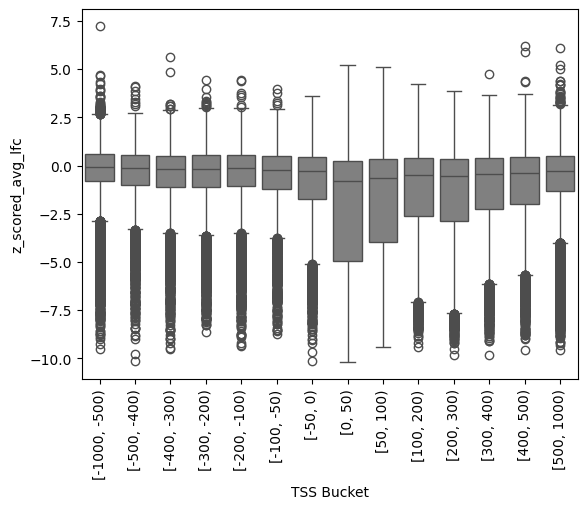

In [22]:
sns.boxplot(
                x = annot_guide_lfcs_A549_Kox1['TSS Bucket'], 
                y = annot_guide_lfcs_A549_Kox1['z_scored_avg_lfc'], color = 'grey')

plt.xticks(rotation=90)


In [14]:

path_out = '../Data/PrimaryLibrary/processed_z_score/'
annot_guide_lfcs_A549_Kox1.to_csv(path_out + 'A549_Kox1_zscore.csv', index = False)